In [1]:
import glob
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import matplotlib as mpl
import sys
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DIR = '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/'

graph_size = []
annotation_size_column = []
annotation_size_flat = []
annotation_size_brwt = []

for i in range(750, 15001, 750):
    graph_size.append(os.path.getsize(DIR + 'graph_subset_{}.dbg'.format(i))
                        + os.path.getsize(DIR + 'graph_subset_{}.edgemask'.format(i)))

    annotation_size_column.append(os.path.getsize(DIR + 'annotation_subset_{}.column.annodbg'.format(i)))
    annotation_size_flat.append(os.path.getsize(DIR + 'annotation_subset_{}.flat.annodbg'.format(i)))
    annotation_size_brwt.append(os.path.getsize(DIR + 'annotation_subset_{}.brwt.annodbg'.format(i)))

results = pd.DataFrame(columns=['n_samples', 'graph', 'anno_column', 'anno_flat', 'anno_brwt'],
                       data=zip(list(range(750, 15001, 750)),
                                graph_size,
                                annotation_size_column,
                                annotation_size_flat,
                                annotation_size_brwt))
results.shape[0]

20

In [3]:
bloom_size = []

for i in range(750, 15001, 750):
    files = !cat subsets/files_{i}.txt
    ids = [f.split('/')[-1].split('.')[0] for f in files]
    bloom_size.append(sum([os.path.getsize(DIR + 'bigsi/bloom/{}.bloom'.format(x)) for x in ids]))

results['bigsi_bloom'] = bloom_size

In [16]:
bigsi_size = []

for i in range(750, 15001, 750):
    try:
        bigsi_size.append(os.path.getsize(DIR + 'bigsi/subsets/index_{}/combined-index'.format(i)))
    except:
        bigsi_size.append(np.nan)

results['bigsi_db'] = bigsi_size

In [17]:
mantis_size = []
mantis_rrr_size = []
mantis_mst_size = []

for i in range(750, 15001, 750):
    try:
        mantis_size.append(os.path.getsize(DIR + 'mantis/cqfs/files_{}/dbg_cqf.ser'.format(i)))
    except:
        mantis_size.append(np.nan)

    files = !find {DIR}mantis/cqfs/files_{i}/ -name *eqclass_rrr.cls
    if len(files):
        mantis_rrr_size.append(sum([os.path.getsize(f) for f in files]))
    else:
        mantis_rrr_size.append(np.nan)

    files = !find {DIR}mantis/cqfs/files_{i}/ -name *.bv
    if len(files) == 3:
        mantis_mst_size.append(sum([os.path.getsize(f) for f in files]))
    else:
        mantis_mst_size.append(np.nan)

results['mantis_index'] = mantis_size
results['mantis_rrr'] = mantis_rrr_size
results['mantis_mst'] = mantis_mst_size

In [20]:
results.loc[range(15, 20), 'bigsi_db'] = np.nan
results.loc[range(15, 20), 'mantis_rbf'] = np.nan
results.loc[range(14, 20), 'mantis_rrr'] = np.nan

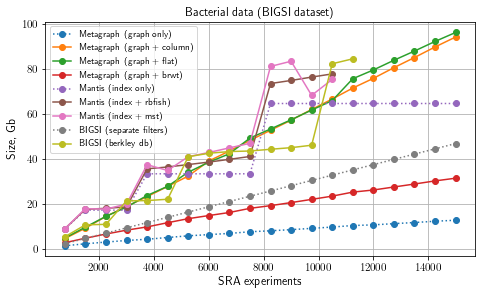

In [21]:
width = 3.487 * 1.5 * 1.3
height = width / 1.618

fig, axes = plt.subplots(1, 1, figsize=(width, height))
#ax.set_title('RefSeq assembly graph')

# results.sort_values('num_kmers', inplace=True)

# colors = ['c', 'b', 'g', 'r']

ax = axes

ax.plot(results.n_samples,
        results.graph / 10**9,
        marker='o', label='Metagraph (graph only)', linestyle=':')

ax.plot(results.n_samples,
        (results.graph + results.anno_column) / 10**9,
        marker='o', label='Metagraph (graph + column)')

ax.plot(results.n_samples,
        (results.graph + results.anno_flat) / 10**9,
        marker='o', label='Metagraph (graph + flat)')

ax.plot(results.n_samples,
        (results.graph + results.anno_brwt) / 10**9,
        marker='o', label='Metagraph (graph + brwt)')


ax.plot(results.n_samples,
        results.mantis_index / 10**9,
        marker='o', label='Mantis (index only)', linestyle=':')

ax.plot(results.n_samples,
        (results.mantis_index + results.mantis_rrr) / 10**9,
        marker='o', label='Mantis (index + rbfish)')

ax.plot(results.n_samples,
        (results.mantis_index + results.mantis_mst) / 10**9,
        marker='o', label='Mantis (index + mst)')


ax.plot(results.n_samples,
        results.bigsi_bloom / 10**9,
        marker='o', label='BIGSI (separate filters)', linestyle=':')

ax.plot(results.n_samples,
        results.bigsi_db / 10**9,
        marker='o', label='BIGSI (berkley db)')

ax.set_title('Bacterial data (BIGSI dataset)')
ax.set_xlabel('SRA experiments')
ax.set_ylabel('Size, Gb')
#     ax.set_xlim([-1e9, 25e9])
#ax.set_xticks(np.array(k_array))
ax.grid(True)
#     ax.legend(loc='best')

ax.legend(loc="best", fontsize=9)
# axes[0].set_ylim([-5, 75])
# axes[1].set_ylim([-1e-1, 75])
# axes[1].set_yscale('symlog')

plt.tight_layout()
plt.savefig('graph_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()